<a href="https://colab.research.google.com/github/DrKenReid/Introductory-Data-Science/blob/main/Day_2_Lab_2_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem/dataset Description:

For this hands-on exercise, we will work with the CIFAR-10 dataset. We will use a CNN for this classification task.

**Click runtime -> change runtime type -> GPU**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load and preprocess the CIFAR-10 dataset

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes include everyday objects such as cars, birds, dogs, and ships.



We first convert images to PyTorch tensors, and then normalize tensor images with mean and standard deviation.

This standardization helps in speeding up the learning process.

In [2]:
# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load and preprocess the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 43023564.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Define the CNN architecture

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


The CNN we initialized has 3 convolutional layers (`conv1` `conv2` `conv3`), each followed by a ReLU activation and a max pooling layer. This helps capture hierarchical features from images.
* the convolutional layers apply a number of filters to the input. For the first one, this layer outputs 16 feature maps by using 16 filters. Each filter is 3 pixels by 3 pixels (`kernel_size`), moves one pixel at a time (`stride`), and adds a one-pixel border around the input to allow the filter to cover the border of the image (`padding`).
* a dropout layer (`nn.Dropout`) with a dropout probability of 0.25 to prevent overfitting by randomly setting input elements to zero during training.
* the pooling layer reduces the spatial dimensions (width and height) of the input volume for the next convolutional layer. We set the kernel size 2 by 2. This reduces the feature map size by taking the maximum value in each 2x2 area of the feature map.

`forward` defines how data flows: through three convolutional layers, ReLU activations, pooling, and fully connected layers ----  `fc1` and `fc2` map the learned features from the convolutional and pooling layers to the final output classes. The first one takes input 128 * 4 * 4 = 512 features, and transforms the input from feature extraction into a vector that can be used for classification. The second one outputs 10 classes, which is the number of classes in CIFAR-10, and provides a score for each class.





# Initialize the CNN model, loss function, and optimizer

In [4]:
net = Net()
# sets up the device on which the network will be trained
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
# the Cross Entropy Loss for our classification task
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

We used an adaptive learning rate optimization algorithm (adam) for our optimizer, which automatically adjusts the learning rate during training.

We set the learning rate to be 0.001.

# Train the CNN model

The model learns by adjusting weights to minimize the loss computed from the outputs and true labels.


This process takes ~15 mins

In [5]:
num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    net.train()

    # Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Store the average training loss for this epoch
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    running_val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

Epoch 1, Training Loss: 1.7389244499718746, Validation Loss: 1.4263083889514585
Epoch 2, Training Loss: 1.4780328548167978, Validation Loss: 1.2906058196780048
Epoch 3, Training Loss: 1.3543002126771775, Validation Loss: 1.198362133170985
Epoch 4, Training Loss: 1.2697967406733872, Validation Loss: 1.119468339636356
Epoch 5, Training Loss: 1.1977893211652555, Validation Loss: 1.0757740117326569
Epoch 6, Training Loss: 1.149902096184928, Validation Loss: 1.0216606840302673
Epoch 7, Training Loss: 1.1160499965748214, Validation Loss: 0.9763127754006204
Epoch 8, Training Loss: 1.0787361430390108, Validation Loss: 0.9361725434472289
Epoch 9, Training Loss: 1.0522030739833022, Validation Loss: 0.9276537072809437
Epoch 10, Training Loss: 1.0321754890939463, Validation Loss: 0.9021536074107206
Epoch 11, Training Loss: 1.016137340794439, Validation Loss: 0.9171890193902994
Epoch 12, Training Loss: 1.0024969268332966, Validation Loss: 0.8753161158742784
Epoch 13, Training Loss: 0.97839837748071

# Model evaluation

In [6]:
# Evaluate the trained model on the test set
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy}%')

Accuracy on the test set: 70.47%


Accuracy on the test set: 73.5%

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

net.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

# Calculate accuracy
accuracy = np.mean(all_labels == all_predictions) * 100
print(f'Overall Accuracy: {accuracy:.2f}%')

# Generate and print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=testset.classes))

# Generate and print the confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_predictions)
print(conf_matrix)


Overall Accuracy: 70.47%
Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.78      0.74      1000
  automobile       0.80      0.84      0.82      1000
        bird       0.65      0.54      0.59      1000
         cat       0.57      0.44      0.49      1000
        deer       0.70      0.64      0.67      1000
         dog       0.52      0.71      0.60      1000
        frog       0.74      0.80      0.77      1000
       horse       0.78      0.71      0.75      1000
        ship       0.85      0.78      0.81      1000
       truck       0.77      0.80      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

Confusion Matrix:
[[783  26  33  13  12  10   9  19  54  41]
 [ 25 845   1  11   0   5   7   3  12  91]
 [ 85   8 542  41  76 108  81  35   8  16]
 [ 26   8  59 438  41 299  67  25  16  21]
 [ 

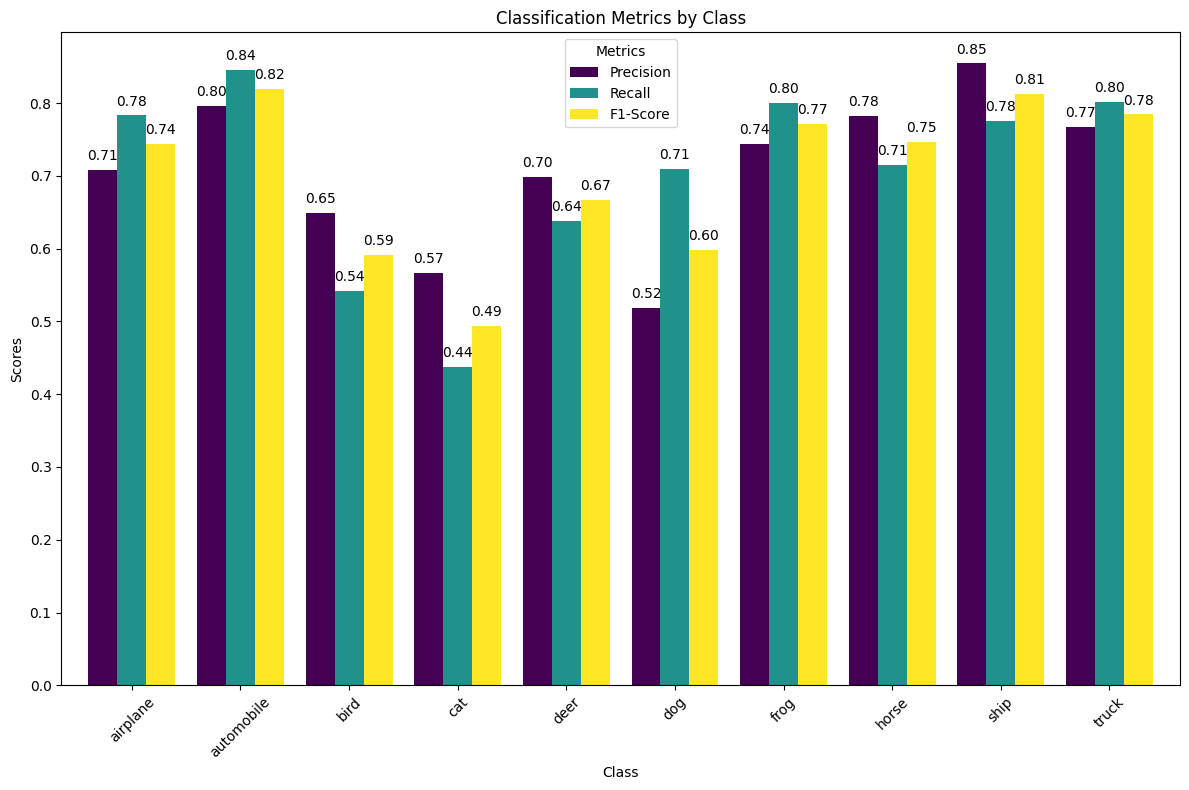

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

report = classification_report(all_labels, all_predictions, target_names=testset.classes, output_dict=True)

classes = list(report.keys())[:-3]  # exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
}, index=classes)

# Plotting side-by-side bar plot
ax = df.plot(kind='bar', figsize=(12, 8), width=0.8, colormap='viridis')
plt.title('Classification Metrics by Class')
plt.xlabel('Class')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(title='Metrics')

for p in ax.patches:  # loop to display the data
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()


Visualize the confusion matrix:

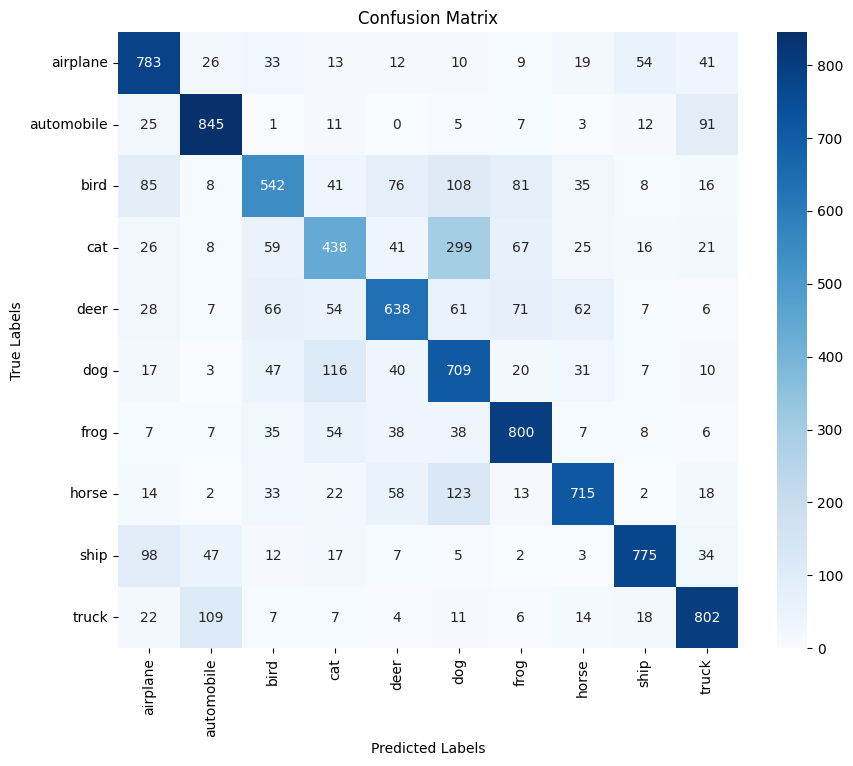

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualizations

Visualize the training and validation loss curves:

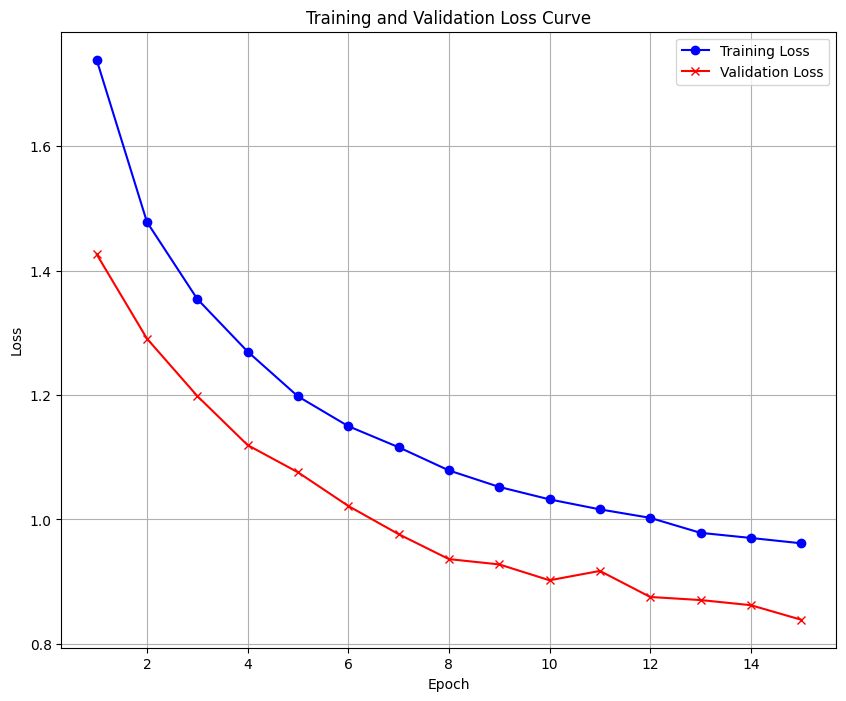

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, marker='x', label='Validation Loss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.grid(True)
plt.legend()
plt.show()


Visualize sample predictions:

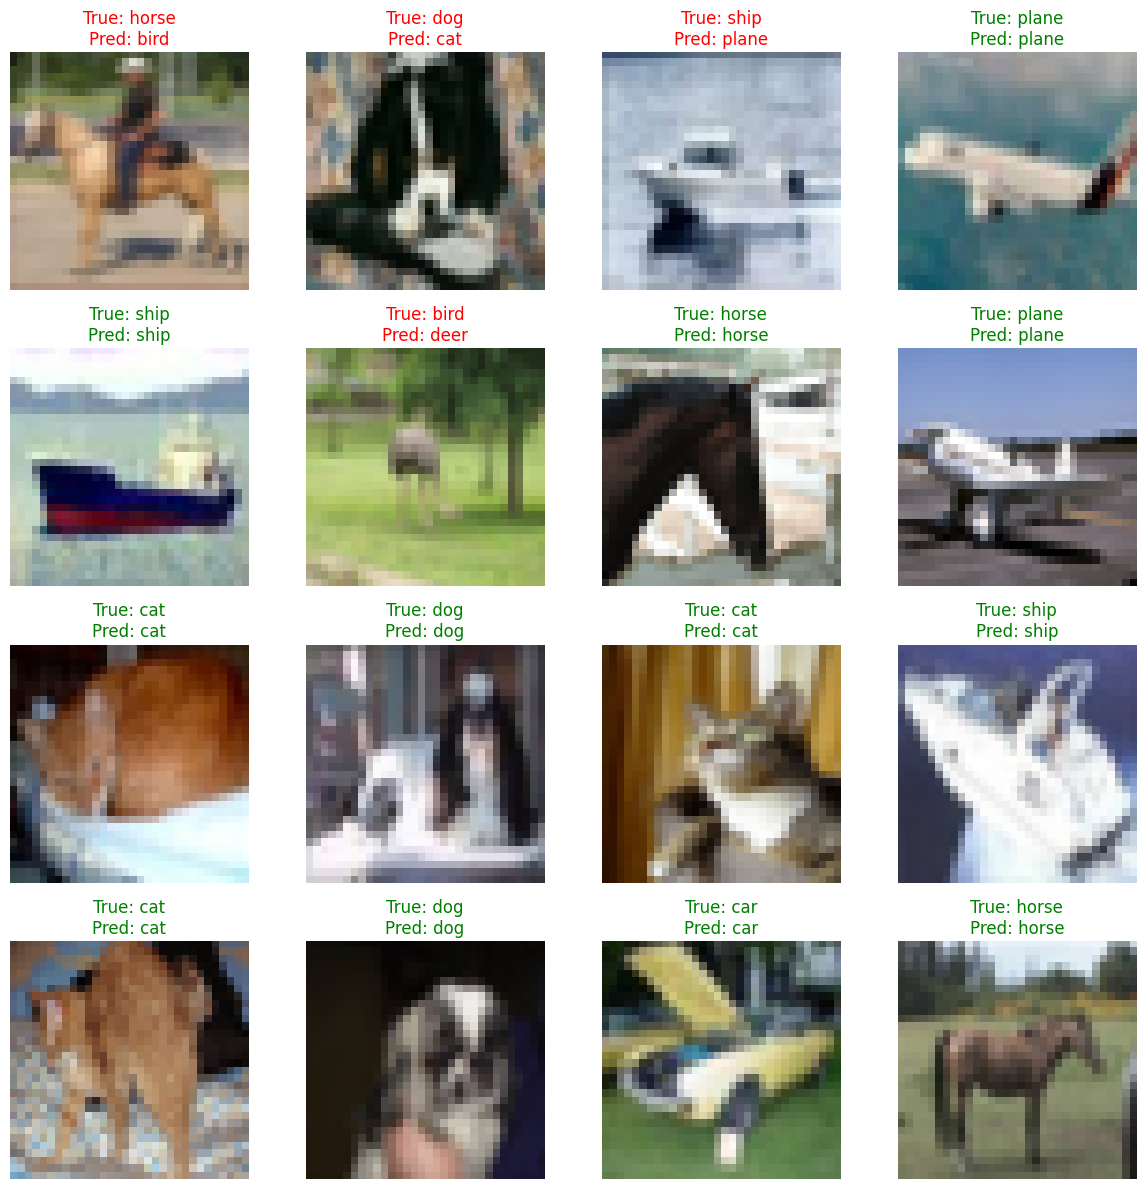

In [12]:
import matplotlib.pyplot as plt
import torch

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to unnormalize for visualization
def unnormalize(image):
    image = image * 0.5 + 0.5
    image = image.clamp(0, 1)

    if image.is_cuda:  # Check if the tensor is on CUDA
        image = image.cpu()  # Move to CPU

    return image.numpy()



fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

# Loop to plot the data
for i in range(16):
    img = unnormalize(images[i]).transpose(1, 2, 0)
    axes[i].imshow(img)
    correct = labels[i] == predicted[i]
    color = 'green' if correct else 'red'
    axes[i].set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}", color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Conclusion

Congratulations on completing this lab on Convolutional Neural Networks (CNNs) using the CIFAR-10 dataset! Throughout this exercise, you've successfully:

1. Loaded and preprocessed the CIFAR-10 dataset using PyTorch and torchvision
2. Implemented data augmentation techniques to improve model generalization
3. Designed and implemented a CNN architecture using PyTorch's nn.Module
4. Set up the training process with CrossEntropyLoss and Adam optimizer
5. Trained the CNN model on the CIFAR-10 dataset
6. Evaluated the model's performance using various metrics:
   - Accuracy
   - Precision
   - Recall
   - F1 Score
7. Visualized the results using:
   - Confusion Matrix
   - Classification metrics by class (bar plot)
   - Training and validation loss curves
   - Sample predictions with true and predicted labels

Key takeaways from this lab:

- Understanding the structure and implementation of CNNs in PyTorch
- The importance of data augmentation in improving model performance
- The process of designing a CNN architecture with convolutional, pooling, and fully connected layers
- The significance of various evaluation metrics in assessing model performance on a multi-class problem
- The value of visualizations in interpreting model results, tracking training progress, and identifying areas for improvement

This lab has provided you with hands-on experience in building, training, and evaluating a CNN for image classification. You've gained insights into the entire deep learning pipeline, from data preparation and augmentation to model architecture design and result interpretation. These skills form a solid foundation for tackling more complex computer vision tasks and understanding advanced CNN architectures.